In [1]:
#meta 1/22/2021 Poker Dataset for Unstructured Data Anomalies
#input: kaggle Poker dataset
#output: translated poker.pkl dataframe
#goal: Explore anomalies with Poker dataset

#history: 
#1/22/2021 TRANSLATE TO POKER LANGUAGE


# Hackathon 2021 - Anomalies in Unstructured Data
## Try Poker Dataset
before we find a more realistic dataset

In [2]:
import time as time #to track performance time
import numpy as np
import pandas as pd #for data processing
import matplotlib.pyplot as plt #for plotting
%matplotlib inline

#state persistence
from joblib import dump, load #to pickle

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer


In [3]:
 #----------------------------------------------- set CONSTANTS and variables -----------------------------------------------
pd.options.display.max_colwidth=None

## 0. Load data
src: Kaggle, CSV with 11 Values:
- 10 Attributes describing cards
- 1 Label describing Poker Hand

Statistics:

      Poker Hand       # of hands	Probability	# of combinations
      Royal Flush      4		    0.00000154	480
      Straight Flush   36		    0.00001385	4320
      Four of a kind   624		    0.0002401	74880
      Full house       3744		    0.00144058	449280
      Flush            5108		    0.0019654	612960
      Straight         10200		0.00392464	1224000
      Three of a kind  54912		0.02112845	6589440
      Two pairs        123552		0.04753902	14826240
      One pair         1098240		0.42256903	131788800
      Nothing          1302540		0.50117739	156304800

      Total            2598960		1.0		    311875200

      The number of combinations represents the number of instances in the entire domain.

CLASS “Poker Hand”
      Ordinal (0-9)

      0: Nothing in hand; not a recognized poker hand 
      1: One pair; one pair of equal ranks within five cards
      2: Two pairs; two pairs of equal ranks within five cards
      3: Three of a kind; three equal ranks within five cards
      4: Straight; five cards, sequentially ranked with no gaps
      5: Flush; five cards with the same suit
      6: Full house; pair + different rank three of a kind
      7: Four of a kind; four equal ranks within five cards
      8: Straight flush; straight + flush
      9: Royal flush; {Ace, King, Queen, Jack, Ten} + flush

In [4]:
df = pd.read_csv("data/train.csv")
print (df.shape)
df.head()

(800000, 11)


,s1,c1,s2,c2,s3,c3,s4,c4,s5,c5,class
0,4,7,3,5,3,3,1,13,4,8,0
1,2,8,4,9,4,6,4,1,3,7,0
2,3,6,1,3,2,11,3,9,2,3,1
3,2,10,2,5,4,13,3,9,1,6,0
4,3,2,1,3,4,7,3,5,1,11,0


In [5]:
#check for nulls - confirmed no nulls
#df.isnull().sum()

#look at types
df.dtypes

s1       int64
c1       int64
s2       int64
c2       int64
s3       int64
c3       int64
s4       int64
c4       int64
s5       int64
c5       int64
class    int64
dtype: object

## 1. Prep Data
### 1.1 Translate into Poker Language
Suit of card:  Numerical (1-4) representing {Hearts, Spades, Diamonds, Clubs}  
Rank of card: Ordinal (1-13) representing (Ace, 2, 3, ... , Queen, King) $actodo: order categories

In [6]:
poker = df.copy()
poker = poker[poker.columns].astype('category')


In [7]:
card_suit = ['s1','s2','s3','s4','s5']
card_rank = ['c1','c2','c3','c4','c5']
class_cat = np.arange(10)

for s in card_suit:
    poker[s].cat.rename_categories({1:'Hearts', 2:'Spades', 3:'Diamonds', 4:'Clubs'}, inplace=True)
for r in card_rank:
    #poker[r].cat.rename_categories({1:'Ace', 11:'Jack', 12:'Queen', 13:'King'}, inplace=True)
    poker[r].cat.rename_categories({1:'Ace', 2: 'Two', 3:'Three', 4:'Four', 5:'Five', 6:'Six', 7:'Seven', 8:'Eight', 9:'Nine', 10:'Ten', 11:'Jack', 12:'Queen', 13:'King'}, inplace=True)
for c in class_cat:
    poker['class'].cat.rename_categories({0:'Nothing', 1:'One pair', 2:'Two pairs', 3: 'Three of a kind', 4:'Straight', 5:'Flush', 6: 'Full house', 7:'Four of a kind', 8:'Straight flush', 9:'Royal flush'}, inplace=True)
        
poker.head()

,s1,c1,s2,c2,s3,c3,s4,c4,s5,c5,class
0,Clubs,Seven,Diamonds,Five,Diamonds,Three,Hearts,King,Clubs,Eight,Nothing
1,Spades,Eight,Clubs,Nine,Clubs,Six,Clubs,Ace,Diamonds,Seven,Nothing
2,Diamonds,Six,Hearts,Three,Spades,Jack,Diamonds,Nine,Spades,Three,One pair
3,Spades,Ten,Spades,Five,Clubs,King,Diamonds,Nine,Hearts,Six,Nothing
4,Diamonds,Two,Hearts,Three,Clubs,Seven,Diamonds,Five,Hearts,Jack,Nothing


In [8]:
#feature engineering - encode each card
poker['c1s1'] = poker['c1'].astype(str) + '_' + poker['s1'].astype(str)
poker['c2s2'] = poker['c2'].astype(str) + '_' + poker['s2'].astype(str)
poker['c3s3'] = poker['c3'].astype(str) + '_' + poker['s3'].astype(str)
poker['c4s4'] = poker['c4'].astype(str) + '_' + poker['s4'].astype(str)
poker['c5s5'] = poker['c5'].astype(str) + '_' + poker['s5'].astype(str)

in_cols = ['c1s1', 'c2s2', 'c3s3', 'c4s4', 'c5s5', 'class']
#poker = poker[in_cols].astype('category')
for col in poker.columns:
    poker[col] = poker[col].astype('category')

#poker.head()

In [9]:
poker['cards'] =poker['c1s1'].astype(str) + ' ' + poker['c2s2'].astype(str) + ' ' + poker['c3s3'].astype(str) + ' ' + poker['c4s4'].astype(str) + ' ' + poker['c5s5'].astype(str)

poker.dtypes

s1       category
c1       category
s2       category
c2       category
s3       category
c3       category
s4       category
c4       category
s5       category
c5       category
class    category
c1s1     category
c2s2     category
c3s3     category
c4s4     category
c5s5     category
cards      object
dtype: object

In [10]:
#save translated poker dataset
dump(poker, 'data/my_poker.pkl')

['data/my_poker.pkl']

### 1.2 Transform into X and y
Assemble Data into ML Expected Format. Scikit-learn expects a Numpy array-like structure. Transform the tidy dataset to a structure acceptable by algorithm: input features X(matrix) and target variable y(vector).

X - columns with all the cards
y - column 'class'

In [11]:
#interested in all cards and PokerHand
X = poker['cards']
#for supervised learning
y = poker['class']

print(X.shape, y.shape)
X.head(), y.head()

(800000,) (800000,)


(0    Seven_Clubs Five_Diamonds Three_Diamonds King_Hearts Eight_Clubs
 1          Eight_Spades Nine_Clubs Six_Clubs Ace_Clubs Seven_Diamonds
 2    Six_Diamonds Three_Hearts Jack_Spades Nine_Diamonds Three_Spades
 3          Ten_Spades Five_Spades King_Clubs Nine_Diamonds Six_Hearts
 4     Two_Diamonds Three_Hearts Seven_Clubs Five_Diamonds Jack_Hearts
 Name: cards, dtype: object,
 0     Nothing
 1     Nothing
 2    One pair
 3     Nothing
 4     Nothing
 Name: class, dtype: category
 Categories (10, object): [Nothing, One pair, Two pairs, Three of a kind, ..., Full house, Four of a kind, Straight flush, Royal flush])

In [12]:
#represent text data as Bag of Words
vect = CountVectorizer()
dtm = vect.fit_transform(X) #scipy.sparse.csr.csr_matrix

print("Vocabulary size: {}".format(len(vect.vocabulary_)))
#print("Vocabulary content:\n {}".format(vect.vocabulary_))
print("\nMatrix shape: {}".format(dtm.shape))

feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
print("First 10 features:\n{}".format(feature_names[:10]))

#Dense representation of sparse matrix
dtm.toarray()

Vocabulary size: 52

Matrix shape: (800000, 52)
Number of features: 52
First 10 features:
['ace_clubs', 'ace_diamonds', 'ace_hearts', 'ace_spades', 'eight_clubs', 'eight_diamonds', 'eight_hearts', 'eight_spades', 'five_clubs', 'five_diamonds']


array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0]], dtype=int64)

In [13]:
#put into df 
import scipy.sparse
X_tidy = pd.DataFrame.sparse.from_spmatrix(dtm, columns = feature_names)
#X_tidy.head()

poker_tidy = pd.concat([X_tidy, y], axis=1)
print(poker_tidy.dtypes)
poker_tidy.head()

ace_clubs         Sparse[int64, 0]
ace_diamonds      Sparse[int64, 0]
ace_hearts        Sparse[int64, 0]
ace_spades        Sparse[int64, 0]
eight_clubs       Sparse[int64, 0]
eight_diamonds    Sparse[int64, 0]
eight_hearts      Sparse[int64, 0]
eight_spades      Sparse[int64, 0]
five_clubs        Sparse[int64, 0]
five_diamonds     Sparse[int64, 0]
five_hearts       Sparse[int64, 0]
five_spades       Sparse[int64, 0]
four_clubs        Sparse[int64, 0]
four_diamonds     Sparse[int64, 0]
four_hearts       Sparse[int64, 0]
four_spades       Sparse[int64, 0]
jack_clubs        Sparse[int64, 0]
jack_diamonds     Sparse[int64, 0]
jack_hearts       Sparse[int64, 0]
jack_spades       Sparse[int64, 0]
king_clubs        Sparse[int64, 0]
king_diamonds     Sparse[int64, 0]
king_hearts       Sparse[int64, 0]
king_spades       Sparse[int64, 0]
nine_clubs        Sparse[int64, 0]
nine_diamonds     Sparse[int64, 0]
nine_hearts       Sparse[int64, 0]
nine_spades       Sparse[int64, 0]
queen_clubs       Sp

,ace_clubs,ace_diamonds,ace_hearts,ace_spades,eight_clubs,eight_diamonds,eight_hearts,eight_spades,five_clubs,five_diamonds,...,ten_spades,three_clubs,three_diamonds,three_hearts,three_spades,two_clubs,two_diamonds,two_hearts,two_spades,class
0,0,0,0,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,Nothing
1,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Nothing
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,One pair
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Nothing
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,Nothing


In [19]:
#save translated poker dataset
dump(poker_tidy, 'data/my_poker_tidy.pkl')

['data/my_poker_tidy.pkl']

## 2. EDA

Nothing            400573
One pair           338169
Two pairs           38173
Three of a kind     16988
Straight             3126
Flush                1620
Full house           1150
Four of a kind        189
Straight flush         10
Royal flush             2
Name: class, dtype: int64


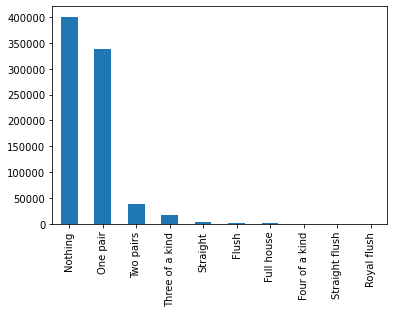

In [14]:
#visualize distribution
print(poker['class'].value_counts().sort_index())
poker['class'].value_counts().sort_index().plot(kind='bar');

Nothing            0.500716
One pair           0.422711
Two pairs          0.047716
Three of a kind    0.021235
Straight           0.003908
Flush              0.002025
Full house         0.001437
Four of a kind     0.000236
Straight flush     0.000013
Royal flush        0.000003
Name: class, dtype: float64


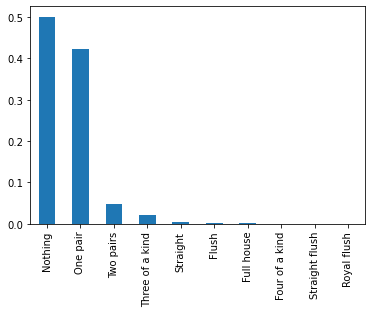

In [15]:
#visualize distribution normalized
print(poker['class'].value_counts(normalize=True).sort_index())
poker['class'].value_counts(normalize=True).sort_index().plot(kind='bar');

#### Explore Minority Classes

In [16]:
poker[poker['class']=='Royal flush']

,s1,c1,s2,c2,s3,c3,s4,c4,s5,c5,class,c1s1,c2s2,c3s3,c4s4,c5s5,cards
725404,Spades,Ace,Spades,Jack,Spades,Queen,Spades,Ten,Spades,King,Royal flush,Ace_Spades,Jack_Spades,Queen_Spades,Ten_Spades,King_Spades,Ace_Spades Jack_Spades Queen_Spades Ten_Spades King_Spades
761600,Clubs,Queen,Clubs,Jack,Clubs,King,Clubs,Ace,Clubs,Ten,Royal flush,Queen_Clubs,Jack_Clubs,King_Clubs,Ace_Clubs,Ten_Clubs,Queen_Clubs Jack_Clubs King_Clubs Ace_Clubs Ten_Clubs


In [17]:
poker[poker['class']=='Straight flush']

,s1,c1,s2,c2,s3,c3,s4,c4,s5,c5,class,c1s1,c2s2,c3s3,c4s4,c5s5,cards
49306,Diamonds,Ace,Diamonds,Five,Diamonds,Two,Diamonds,Four,Diamonds,Three,Straight flush,Ace_Diamonds,Five_Diamonds,Two_Diamonds,Four_Diamonds,Three_Diamonds,Ace_Diamonds Five_Diamonds Two_Diamonds Four_Diamonds Three_Diamonds
212447,Diamonds,Ten,Diamonds,Jack,Diamonds,Nine,Diamonds,King,Diamonds,Queen,Straight flush,Ten_Diamonds,Jack_Diamonds,Nine_Diamonds,King_Diamonds,Queen_Diamonds,Ten_Diamonds Jack_Diamonds Nine_Diamonds King_Diamonds Queen_Diamonds
213651,Spades,Five,Spades,Six,Spades,Eight,Spades,Seven,Spades,Four,Straight flush,Five_Spades,Six_Spades,Eight_Spades,Seven_Spades,Four_Spades,Five_Spades Six_Spades Eight_Spades Seven_Spades Four_Spades
215570,Spades,Seven,Spades,Jack,Spades,Eight,Spades,Ten,Spades,Nine,Straight flush,Seven_Spades,Jack_Spades,Eight_Spades,Ten_Spades,Nine_Spades,Seven_Spades Jack_Spades Eight_Spades Ten_Spades Nine_Spades
257552,Clubs,Six,Clubs,Four,Clubs,Seven,Clubs,Five,Clubs,Eight,Straight flush,Six_Clubs,Four_Clubs,Seven_Clubs,Five_Clubs,Eight_Clubs,Six_Clubs Four_Clubs Seven_Clubs Five_Clubs Eight_Clubs
434662,Spades,Nine,Spades,Jack,Spades,Ten,Spades,Queen,Spades,King,Straight flush,Nine_Spades,Jack_Spades,Ten_Spades,Queen_Spades,King_Spades,Nine_Spades Jack_Spades Ten_Spades Queen_Spades King_Spades
462969,Hearts,Five,Hearts,Seven,Hearts,Six,Hearts,Eight,Hearts,Nine,Straight flush,Five_Hearts,Seven_Hearts,Six_Hearts,Eight_Hearts,Nine_Hearts,Five_Hearts Seven_Hearts Six_Hearts Eight_Hearts Nine_Hearts
469202,Clubs,Ten,Clubs,Seven,Clubs,Eight,Clubs,Jack,Clubs,Nine,Straight flush,Ten_Clubs,Seven_Clubs,Eight_Clubs,Jack_Clubs,Nine_Clubs,Ten_Clubs Seven_Clubs Eight_Clubs Jack_Clubs Nine_Clubs
659788,Hearts,Five,Hearts,Three,Hearts,Four,Hearts,Seven,Hearts,Six,Straight flush,Five_Hearts,Three_Hearts,Four_Hearts,Seven_Hearts,Six_Hearts,Five_Hearts Three_Hearts Four_Hearts Seven_Hearts Six_Hearts
760611,Clubs,Jack,Clubs,Queen,Clubs,King,Clubs,Ten,Clubs,Nine,Straight flush,Jack_Clubs,Queen_Clubs,King_Clubs,Ten_Clubs,Nine_Clubs,Jack_Clubs Queen_Clubs King_Clubs Ten_Clubs Nine_Clubs


In [18]:
mystop

NameError: name 'mystop' is not defined

## Xtra

In [ ]:
#$xtra
#dump(dtm, "data/my_poker_cards_dtm.pkl")
dump(dtm.toarray(), "data/my_poker_cards_dtm_array.pkl")
dump(y.to_list(), "data/my_poker_cards_class_list.pkl")
dump(y, "data/my_poker_cards_class_series.pkl")